In [5]:
from collections import defaultdict
from copy import deepcopy
from pprint import pprint
from tqdm import tqdm

In [6]:

q = 5
F.<a> = GF(q)
d = 3

R.<x> = PolynomialRing(F)
p = F.characteristic()
r = F.degree()

# PGL = [(x + b)/(c*x + d) for b in F for c in F for d in F if d - b*c != 0] + [1 / (c*x + d) for c in F for d in F if c != 0]

def check(s, t):
    poly = x^4 - 2*x^3 - s*x^2 - 2*t*x + t
    return not any(root[0]^3 != -t for root in poly.roots())

# deg3ratls = set(f / (x^3 + g) for f in R.polynomials(max_degree=2) for g in R.polynomials(max_degree=2) if gcd(f, x^3 + g) == 1)

deg3ratls = set((x^3 + s*x + t) / (x * (x - 1)) for s in F for t in F if t != 0 and 1 + s + t != 0 and check(s, t))


In [7]:
def numRatlEquivClasses(p, q, n): 
    def A(q, n): 
        a = sum([euler_phi(d) * (q^(2*n/d-2) + (d-1)*(q^(2*n/d)-1)/(q+1)) for d in divisors(gcd(q-1, n)) if d > 1])
        b = sum([euler_phi(d) * (q^(2*floor(n/d)+1) + 1)/(q+1) for d in divisors(q-1) if (d not in divisors(n))])
        return a + b 

    def B(q, n):
        a = sum([euler_phi(d) * (q^(2*n/d-2) + (q+1) * (q^(2*n/d) - (-1)^(n/d))/(q^2 + 1)) for d in divisors(gcd((q+1), n)) if d % 2 == 0])
        b = sum([euler_phi(d) * q^(2*n/d-2) for d in divisors(gcd((q+1), n)) if (d % 2 == 1 and d > 1)])
        c = 1/((q+1)*(q^2+1)) * sum([euler_phi(d) * ((1+(-1)^(n//d))/2 * (1+q)^2 + q*(q^(2 * n//d + 2) -1)) for d in divisors(q+1) if d not in divisors(n)])
        d = 1/(q^2 + 1) * sum([euler_phi(d) * ((-1)^(n//d) * (1+q) + q^(2 * (n//d) + 1) * (q-1)) for d in divisors(q+1) if d in divisors(q+1) if d not in divisors(n)])
        # print("B terms are", a, b, c, d)
        return a + b + d

    def C(q, n):
        if n % p == 0:
            return q^(2*n/p-1) 
        elif n == 1: 
            return 1 
        elif n % p == 1: 
            return q^(2*(n-1)/p-1) * (q-1) 
        else: 
            return 0

    # print("Each components is", A(q, n), B(q, n), C(q, n))
    
    return (q^(2*n-3))/(q^2-1) + 1/(2*(q-1)) * A(q, n) + 1/(2*(q+1)) * B(q, n) + 1/q * C(q,n)

In [8]:
print(numRatlEquivClasses(p, q, d))

10


In [9]:
# very slow code; pls scratch this later on but I needed some data for very small case 
PGL = [(x + b)/(c*x + d) for b in F for c in F for d in F if d - b*c != 0] + [1 / (c*x + d) for c in F for d in F if c != 0]

def valueFreq(f): 
    """given a rational function f, compute the value frequency of it"""
    frequencies = defaultdict(int)
    for a in F:
        try: 
            value = f(a)
        except ZeroDivisionError: 
            value = "infinity" 
        frequencies[value] += 1
    return sorted(frequencies.values()) 

def ratlEquiv(f, g):
    """returns whether or not f is PGL-equiv to g""" 
    if valueFreq(f) != valueFreq(g): 
        return (False,) 
    for alpha in PGL: 
        for beta in PGL: 
            try:
                if alpha(f(beta)) == g: 
                    return (True, alpha, beta)
            except ZeroDivisionError: 
                continue
    return (False,)

In [10]:
def reallyslowRatlEquivClasses(print_progress=False): 
    classes = defaultdict(set)
    total = len(deg3ratls)
    candidates = deepcopy(deg3ratls)
    if print_progress:
        print(f"{total - len(candidates)} out of {total} done", end="\r")
    while candidates:
        f = candidates.pop()
        classes[f].add(f)
        for alpha in PGL: 
            for beta in PGL: 
                try: 
                    g = alpha(f(beta))
                    if g in candidates:
                        classes[f].add(g)
                        candidates.discard(g)
                except ZeroDivisionError: 
                    continue
        # classes.add(f)
        if print_progress:
            print(f"{total - len(candidates)} out of {total} done", end="\r")
    if print_progress:
        print()
    return classes

In [11]:
classes = reallyslowRatlEquivClasses(print_progress=True)
print(len(classes))
pprint(classes.keys())

# value_freqs = []
# for f in tqdm(classes):
#     value_freqs.append((f, valueFreq(f)))
# pprint(value_freqs)

10 out of 10 done
4
dict_keys([(x^3 + 4*x + 4)/(x^2 + 4*x), (x^3 + 2)/(x^2 + 4*x), (x^3 + 2*x + 1)/(x^2 + 4*x), (x^3 + x + 1)/(x^2 + 4*x)])


In [12]:
def getOrbit(f):
    s = f.numerator()[1]
    t = f.numerator()[0]

    preimages = defaultdict(set)
    for a in F:
        if a != 0 and a != 1:
            preimages[f(a)].add(a)
    
    pairs = { (s, t) }
    for preimage in preimages.values():
        if len(preimage) == 3:
            u, v, w = preimage
            s_prime = (u^2*(-1 + v)*v*(u - w) - u*(-1 + v)*v^2*(u - w) + u*(u - v)*v^2*(-1 + w) + (1 - v)*v^2*(u - w)*w + (-1 + v)*v^2*(u - w)*w - u^2*(u - v)*(-1 + w)*w + v^2*(-u + v)*(-1 + w)*w - u*(-1 + v)*(u - w)*w^2 + (-1 + v)*v*(u - w)*w^2 + u*(u - v)*(-1 + w)*w^2 + (u - v)*v*(-1 + w)*w^2 + v*(-u + v)*(-1 + w)*w^2) / (u^2*(u - v)*(-1 + w)*w - 2*u*(u - v)*v*(-1 + w)*w + (u - v)*v^2*(-1 + w)*w)
            t_prime = (-(u^2*(-1 + v)*v*(u - w)) + 2*u*(-1 + v)*v*(u - w)*w - (-1 + v)*v*(u - w)*w^2)/(u^2*(u - v)*(-1 + w)*w - 2*u*(u - v)*v*(-1 + w)*w + (u - v)*v^2*(-1 + w)*w)
            pairs.add((s_prime, t_prime))

    # print(pairs)
    
    def get(s, t):
        return {
            (s, t),
            (s / t, 1 / t),
            (s, -1 - s - t),
            (s / t, -(1 + s + t) / t),
            (-s / (1 + s + t), -1 / (1 + s + t)),
            (-s / (1 + s + t), -t / (1 + s + t))
        }
    
    pairs = set.union(*(get(s, t) for s, t in pairs))
    return set((x^3 + s*x + t) / (x^2 - x) for s, t in pairs)

def ratlEquivClassesCase3(print_progress=False):
    classes = defaultdict(set)
    total = len(deg3ratls)
    candidates = deepcopy(deg3ratls)
    if print_progress:
        print(f"{total - len(candidates)} out of {total} done", end="\r")
    while candidates:
        f = candidates.pop()
        orbit = getOrbit(f)
        classes[f] = orbit
        candidates -= orbit
        if print_progress:
            print(f"{total - len(candidates)} out of {total} done", end="\r")
    if print_progress:
        print()
    return classes

In [13]:
getOrbit((x^3 + 3*x + 6) / (x^2 - x))

{(x^3 + 4*x + 1)/(x^2 + 4*x),
 (x^3 + x + 4)/(x^2 + 4*x),
 (x^3 + 4*x + 4)/(x^2 + 4*x)}

In [14]:
classes = ratlEquivClassesCase3(print_progress=True)
print(len(classes))
pprint(classes.keys())

10 out of 10 done
4
dict_keys([(x^3 + 4*x + 4)/(x^2 + 4*x), (x^3 + 2)/(x^2 + 4*x), (x^3 + 2*x + 1)/(x^2 + 4*x), (x^3 + x + 1)/(x^2 + 4*x)])


In [15]:
s, t = F(2), F(3)
ratlEquiv((x^3 + (-s / (1 + s + t))*x + (-t / (1 + s + t)))/(x^2 - x), (x^3 + s*x + t)/(x^2 - x))

(True, x + 2, x/(x + 4))

In [16]:
def ratlEquivClassesCase2():
    out = set() 
    if q % 3 == 1: 
        C = [F.primitive_element()^i for i in range(3)]
    else: 
        C = [1]
    for t in C: 
        out.add((x^3 + t)/x)
    
    for t in F: 
        if t != 0: 
            out.add((x^3 + x^2 + t)/x)
    
    return out 

def qnr(): 
    qrs = quadratic_residues(q)
    a = 2
    while a in qrs: 
        a += 1
    return a

def ratlEquivClassesCase1():
    if q % 6 == 1: 
        b = -qnr() 
        a = F(-9)/F(b) 
        return {(x^3 + a*x)/(b*x^2+1)}
    elif q % 6 == 3: 
        a = -qnr() 
        return {x^3, x^3 + a*x}
    elif q % 6 == 4: 
        return "I'll implement this later"
    else: 
        return {x^3}

def ratlEquivClasses():
    case1 = ratlEquivClassesCase1()
    case2 = ratlEquivClassesCase2() 
    case3 = ratlEquivClassesCase3().keys()
    return case1 | case2 | case3
        

In [17]:
def smallRamifications(): 
    sigma = qnr()
    return {x^3, x^3 -3*x, (x^3+3*sigma*x)/(3*x^2+sigma), x^3 - 3 * sigma * x}    

In [18]:
equivs = ratlEquivClasses()
pprint(equivs)
pprint(smallRamifications())

{x^3,
 (x^3 + 1)/x,
 (x^3 + x^2 + 1)/x,
 (x^3 + x + 1)/(x^2 + 4*x),
 (x^3 + 2*x + 1)/(x^2 + 4*x),
 (x^3 + 2)/(x^2 + 4*x),
 (x^3 + x^2 + 2)/x,
 (x^3 + x^2 + 3)/x,
 (x^3 + x^2 + 4)/x,
 (x^3 + 4*x + 4)/(x^2 + 4*x)}
{x^3 + 2*x, (2*x^3 + 2*x)/(x^2 + 4), x^3, x^3 + 4*x}


In [19]:
def ramCase(f): 
    df = factor(derivative(f).numerator())
    deg2termcounter = 0 
    for term in list(df): 
        deg = term[0].degree()
        if deg == 3: 
            return 3
        elif deg == 4: 
            return 5 
        elif deg == 2: 
            deg2termcounter += term[1]
    if deg2termcounter == 1: 
        return 2 
    elif deg2termcounter == 2: 
        return 4 
    else: 
        return 1 
    

def ram4Classes(): 
    cases = {1: 0, 2: 0, 3:0, 4: 0, 5: 0}
    equivs = ratlEquivClasses() 
    for f in equivs: 
        cases[ramCase(f)] += 1 

    for f in smallRamifications(): 
        cases[ramCase(f)] -= 1
    return cases
    

In [20]:
print(ram4Classes())

{1: 0, 2: 2, 3: 2, 4: 0, 5: 2}


In [22]:
maxq = 500
data = [[] for _ in range(5)]
for p in primes(4, maxq):  
    print(f"Doing prime {p}", end="\r")
    q = p
    F.<a> = GF(q)
    d = 3

    R.<x> = PolynomialRing(F)
    p = F.characteristic()
    r = F.degree()
    def check(s, t):
        poly = x^4 - 2*x^3 - s*x^2 - 2*t*x + t
        return not any(root[0]^3 != -t for root in poly.roots())
    deg3ratls = set((x^3 + s*x + t) / (x * (x - 1)) for s in F for t in F if t != 0 and 1 + s + t != 0 and check(s, t))
    for i in range(5): 
        data[i].append([p, ram4Classes()[i+1]]) 

[[5, 0], [7, 1], [11, 1], [13, 2], [17, 2], [19, 3], [23, 3], [29, 4], [31, 5], [37, 6], [41, 6], [43, 7], [47, 7], [53, 8], [59, 9], [61, 11], [67, 11], [71, 11], [73, 12], [79, 13], [83, 13], [89, 14], [97, 16], [101, 16], [103, 17], [107, 17], [109, 19], [113, 18], [127, 21], [131, 21], [137, 22], [139, 23], [149, 24], [151, 25], [157, 26], [163, 27], [167, 27], [173, 28], [179, 29], [181, 30], [191, 31], [193, 32], [197, 32], [199, 33], [211, 35], [223, 37], [227, 37], [229, 38], [233, 38], [239, 39], [241, 41], [251, 41], [257, 42], [263, 43], [269, 44], [271, 45], [277, 46], [281, 46], [283, 47], [293, 48], [307, 51], [311, 51], [313, 52], [317, 52], [331, 55], [337, 56], [347, 57], [349, 58], [353, 58], [359, 59], [367, 61], [373, 62], [379, 63], [383, 63], [389, 64], [397, 66], [401, 66], [409, 69], [419, 69], [421, 71], [431, 71], [433, 72], [439, 73], [443, 73], [449, 74], [457, 76], [461, 76], [463, 77], [467, 77], [479, 79], [487, 81], [491, 81], [499, 83]]


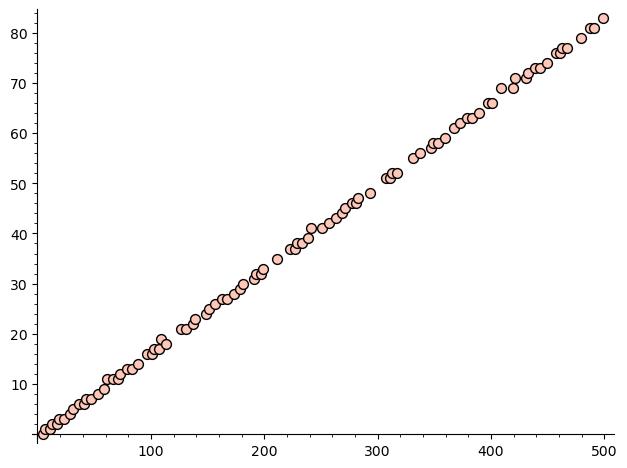

In [24]:
print(data[0])
scatter_plot(data[0])

In [38]:
f1 = lambda x: (x+1)/2
f2 = lambda x: (x-1)/2
print([point for point in data[4] if not ((point[1] == f1(point[0]) and point[0] % 60 == 7 or point[0] % 60 == 43) or (point[1] == f2(point[0])))])

[]
